In [1]:
import torch
import torch.nn as nn
import torch_directml
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

from pathlib import Path
from torchvision.transforms import v2
from torchvision import datasets
from torch.utils.data import DataLoader
from model import mobilevig
from tqdm.auto import tqdm
from timeit import default_timer as timer
from PIL import Image
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from IPython.display import display, HTML, clear_output

d:\KULIAH SEMT 8 AFFAN\SKRIPSI\Skripsi_DL\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Parameters
NUM_EPOCHS = 50
BATCH_SIZE = 7
NUM_WORKERS = 2
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0.

In [20]:
# Path for save results
result_train_dir = "./training_results/batch_size_7/scene_6/r_training.csv"
result_g_dir = "./training_results/batch_size_7/scene_6/g_result.png"
result_cm_dir = "./training_results/batch_size_7/scene_6/cm_result.png"
result_e_dir =  "./training_results/batch_size_7/scene_6"
result_m_dir = "./training_results/batch_size_7/scene_6/m_MobileViG_s_50_epoch_0.5_d.pth"

In [51]:
# Paths
train_dir = Path("./dataset/train/")
test_dir = Path("./dataset/test/")
class_names = os.listdir(test_dir)
print(class_names)

['Benchpress', 'Deadlift', 'Squat']


In [15]:
# Transforms
train_transforms = v2.Compose([
    v2.Resize((224, 224)),  # Resize images to 224x224 pixels
    v2.RandomHorizontalFlip(),  # Randomly flip images horizontally
    v2.RandomRotation(degrees=15),  # Randomly rotate images by ±15 degrees
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, saturation, and hue
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

test_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [23]:
# Load datasets
train_dataset = datasets.ImageFolder(str(train_dir), transform=train_transforms)
test_dataset = datasets.ImageFolder(str(test_dir), transform=test_transforms)

In [24]:
# DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle the data for training
    num_workers=NUM_WORKERS,
    pin_memory=True,
    # drop_last=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Do not shuffle test data
    num_workers=NUM_WORKERS,
    pin_memory=True,
    # drop_last=True
)

In [33]:
# Model Setup
device = torch_directml.device()
model = mobilevig.mobilevig_s(
    dropout=DROPOUT_RATE, 
    num_classes=len(class_names)
    ).to(device)

In [30]:
# Optimizer and Loss Function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [31]:
# Learning Rate Scheduler
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=num_training_steps
)

In [32]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.01, use_accuracy=False):
        self.patience = patience
        self.min_delta = min_delta
        self.use_accuracy = use_accuracy
        self.counter = 0
        self.best_loss = float('inf')
        self.best_accuracy = 0.0
        self.early_stop = False

    def __call__(self, train_loss, test_loss, train_accuracy=None, test_accuracy=None):
        # Check if there is an improvement in the test loss
        if test_loss < self.best_loss - self.min_delta:
            self.best_loss = test_loss
            self.counter = 0
        else:
            self.counter += 1

        # Check if there is an improvement in the test accuracy (if use_accuracy is True)
        if self.use_accuracy and test_accuracy is not None:
            if test_accuracy > self.best_accuracy + self.min_delta:
                self.best_accuracy = test_accuracy
                self.counter = 0
            else:
                self.counter += 1

        # Check for overfitting based on loss
        if train_loss < test_loss - self.min_delta:
            self.counter += 1

        # Check for underfitting based on loss
        # if train_loss > test_loss + self.min_delta:
        #     self.counter += 1

        # Check for overfitting based on accuracy (if use_accuracy is True)
        if self.use_accuracy and train_accuracy is not None and test_accuracy is not None:
            if train_accuracy > test_accuracy + self.min_delta:
                self.counter += 1

        # # Check for underfitting based on accuracy (if use_accuracy is True)
        # if self.use_accuracy and train_accuracy is not None and test_accuracy is not None:
        #     if train_accuracy < test_accuracy - self.min_delta:
        #         self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

        return self.early_stop

In [33]:
# Training and evaluation functions
def train_step(model, dataloader, loss_fn, optimizer, device, pbar):
    model.train()  # Set model to training mode
    train_loss, train_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()  # Zero the gradients
        y_pred = model(X)  # Make predictions
        loss = loss_fn(y_pred, y)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        train_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)  # Get predicted classes
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        pbar.update(1)

    train_loss /= len(dataloader)
    train_acc = (train_acc / len(dataloader))
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device, pbar):
    model.eval()  # Set model to evaluation mode
    test_loss, test_acc = 0, 0

    with torch.no_grad():  # Disable gradient computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)  # Make predictions
            loss = loss_fn(test_pred_logits, y)  # Calculate loss
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)  # Get predicted classes
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

            pbar.update(1)

    test_loss /= len(dataloader)
    test_acc = (test_acc / len(dataloader))
    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, lr_scheduler, epochs, device):
    results = {"Epoch": [], "Train Loss": [], "Test Loss": [], "Train Accuracy": [], "Test Accuracy": [], "Learning Rate": []}
    # early_stopping = EarlyStopping(patience=10, min_delta=0.01, use_accuracy=True)  # Menggunakan akurasi dalam early stopping

    for epoch in range(epochs):
        with tqdm(total=len(train_dataloader) + len(test_dataloader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device, pbar)
            test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device, pbar)
            lr_scheduler.step()

            current_lr = lr_scheduler.get_last_lr()
            results["Epoch"].append(epoch + 1)
            results["Train Loss"].append(train_loss)
            results["Test Loss"].append(test_loss)
            results["Train Accuracy"].append(train_acc)
            results["Test Accuracy"].append(test_acc)
            results["Learning Rate"].append(current_lr)

            # Print results in a table format
            results_df = pd.DataFrame(results)
            results_df["Train Accuracy"] = results_df["Train Accuracy"].apply(lambda x: f"{x*100:.2f}%")
            results_df["Test Accuracy"] = results_df["Test Accuracy"].apply(lambda x: f"{x*100:.2f}%")
            results_df["Learning Rate"] = results_df["Learning Rate"].apply(lambda x: f"{x[0]:.10f}")  # Format learning rate

            clear_output(wait=True)
            
            # Display DataFrame with borders
            display(HTML(results_df.to_html(index=False, border=1)))
            
            # Print debug information
            # print(f"Epoch {epoch + 1}/{epochs}")
            # print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
            # print(f"Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%")
            # print(f"Early Stopping Counter: {early_stopping.counter}")
            # print(f"Best Test Loss: {early_stopping.best_loss:.4f}")
            # if early_stopping.use_accuracy:
            #     print(f"Best Test Accuracy: {early_stopping.best_accuracy*100:.2f}%")
            # print(f"Delta Loss: {test_loss - early_stopping.best_loss:.4f}")
            # if early_stopping.use_accuracy:
            #     print(f"Delta Accuracy: {(test_acc - early_stopping.best_accuracy)*100:.2f}%")

            # if early_stopping(train_loss, test_loss, train_accuracy=train_acc, test_accuracy=test_acc):
            #     print("Early stopping")
            #     # Print final debug information for the last epoch
            #     last_epoch = len(results["Epoch"]) - 1
            #     print(f"Epoch {results['Epoch'][last_epoch]}/{epochs}")
            #     print(f"Train Loss: {results['Train Loss'][last_epoch]:.4f}, Test Loss: {results['Test Loss'][last_epoch]:.4f}")
            #     print(f"Train Acc: {results['Train Accuracy'][last_epoch]*100:.2f}%, Test Acc: {results['Test Accuracy'][last_epoch]*100:.2f}%")
            #     print(f"Early Stopping Counter: {early_stopping.counter}")
            #     print(f"Best Test Loss: {early_stopping.best_loss:.4f}")
            #     if early_stopping.use_accuracy:
            #         print(f"Best Test Accuracy: {early_stopping.best_accuracy*100:.2f}%")
            #     print(f"Delta Loss: {results['Test Loss'][last_epoch] - early_stopping.best_loss:.4f}")
            #     if early_stopping.use_accuracy:
            #         print(f"Delta Accuracy: {(results['Test Accuracy'][last_epoch] - early_stopping.best_accuracy)*100:.2f}%")
            #     break

    return results

In [34]:
# Run training
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

trained_model = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    lr_scheduler=lr_scheduler,
    epochs=NUM_EPOCHS,
    device=device,
)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

Epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Learning Rate
1,6.370044,5.102649,13.10%,42.86%,0.0000999999
2,5.170695,4.001312,34.71%,55.71%,0.0000999997
3,4.602222,3.566007,38.64%,55.71%,0.0000999994
4,3.797029,3.046749,44.14%,55.71%,0.0000999990
5,3.053622,2.919684,47.62%,48.57%,0.0000999984
6,2.418050,2.031296,49.36%,61.43%,0.0000999977
7,2.183931,2.101474,48.90%,60.00%,0.0000999968
8,1.821662,1.424906,52.11%,68.57%,0.0000999958
9,1.538987,1.478483,53.66%,77.14%,0.0000999947
10,1.361897,1.762829,55.59%,64.29%,0.0000999935


Epoch 41/50:  82%|████████▏ | 36/44 [01:47<00:23,  2.98s/batch]


KeyboardInterrupt: 

In [17]:
# Fungsi untuk menyimpan hasil training ke dalam file CSV
def save_training_results(results, filepath):
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(filepath, index=False)
    print(f"Training results saved to {filepath}")

In [18]:
# Simpan hasil training ke dalam file CSV
save_training_results(trained_model, result_train_dir)

Training results saved to ./training_results/batch_size_7/scene_6/r_training.csv


In [19]:
# Display for every 10 Epoch
results = {"Epoch": [], "Train Loss": [], "Test Loss": [], "Train Accuracy": [], "Test Accuracy": [], "Learning Rate": []}

# Iterate through epochs and add data to results
for epoch in range(len(trained_model['Epoch'])):
    if epoch == 0 or (epoch + 1) % 10 == 0 or epoch == len(trained_model['Epoch']) - 1:
        results["Epoch"].append(trained_model['Epoch'][epoch])
        results["Train Loss"].append(trained_model['Train Loss'][epoch])
        results["Test Loss"].append(trained_model['Test Loss'][epoch])
        results["Train Accuracy"].append(f"{trained_model['Train Accuracy'][epoch]*100:.2f}%")
        results["Test Accuracy"].append(f"{trained_model['Test Accuracy'][epoch]*100:.2f}%")
        results["Learning Rate"].append(f"{trained_model['Learning Rate'][epoch][0]:.10f}")  # Assuming LR is a list with a single element

# Create DataFrame
results_df = pd.DataFrame(results)

# Display DataFrame with borders
display(HTML(results_df.to_html(index=False, border=1)))

Epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Learning Rate
1,6.671692,5.701616,10.53%,35.71%,0.0000999999
10,1.520467,1.269390,50.09%,68.57%,0.0000999935
20,0.762232,0.630217,74.82%,82.86%,0.0000999740
30,0.523803,0.519866,80.59%,80.00%,0.0000999416
40,0.511862,0.807073,80.77%,64.29%,0.0000998962
50,0.436902,0.695599,84.25%,74.29%,0.0000998379


In [20]:
# Visualization of Training Progress
def plot_training_progress(results, save_path=None):
    epochs = len(results["Train Loss"])
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Training Progress Over Epochs', fontsize=16)
    
    # Define colors with transparency
    train_loss_color = 'blue'
    train_acc_color = 'green'
    test_loss_color = (0, 0, 1, 0.5)  # Blue with transparency
    test_acc_color = (0, 1, 0, 0.5)   # Green with transparency

    # Plot Loss
    axes[0].plot(range(epochs), results["Train Loss"], label='Train Loss', color=train_loss_color, linestyle='-')
    axes[0].plot(range(epochs), results["Test Loss"], label='Test Loss', color=test_loss_color, linestyle='-')
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss over Epochs', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Highlight min and max points
    min_train_loss = min(results["Train Loss"])
    min_test_loss = min(results["Test Loss"])
    axes[0].annotate(f'Min Train Loss: {min_train_loss:.4f}', xy=(results["Train Loss"].index(min_train_loss), min_train_loss), 
                    xytext=(results["Train Loss"].index(min_train_loss), min_train_loss + 0.1),
                    arrowprops=dict(facecolor='blue', shrink=0.04))
    axes[0].annotate(f'Min Test Loss: {min_test_loss:.4f}', xy=(results["Test Loss"].index(min_test_loss), min_test_loss), 
                    xytext=(results["Test Loss"].index(min_test_loss), min_test_loss + 0.1),
                    arrowprops=dict(facecolor='red', shrink=0.04))

    # Convert accuracy to percentage
    train_accuracy_percentage = [acc * 100 for acc in results["Train Accuracy"]]
    test_accuracy_percentage = [acc * 100 for acc in results["Test Accuracy"]]

    # Plot Accuracy
    axes[1].plot(range(epochs), train_accuracy_percentage, label='Train Accuracy', color=train_acc_color, linestyle='-')
    axes[1].plot(range(epochs), test_accuracy_percentage, label='Test Accuracy', color=test_acc_color, linestyle='-')
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Accuracy over Epochs', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Highlight max points
    max_train_acc = max(train_accuracy_percentage)
    max_test_acc = max(test_accuracy_percentage)
    axes[1].annotate(f'Max Train Acc: {max_train_acc:.2f}%', xy=(train_accuracy_percentage.index(max_train_acc), max_train_acc), 
                    xytext=(train_accuracy_percentage.index(max_train_acc), max_train_acc - 5),
                    arrowprops=dict(facecolor='green', shrink=0.04))
    axes[1].annotate(f'Max Test Acc: {max_test_acc:.2f}%', xy=(test_accuracy_percentage.index(max_test_acc), max_test_acc), 
                    xytext=(test_accuracy_percentage.index(max_test_acc), max_test_acc - 5),
                    arrowprops=dict(facecolor='orange', shrink=0.04))

    # Adding borders to subplots
    for ax in axes:
        ax.spines['top'].set_linewidth(1.5)
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_linewidth(1.5)
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['left'].set_color('black')
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Set a more professional background
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

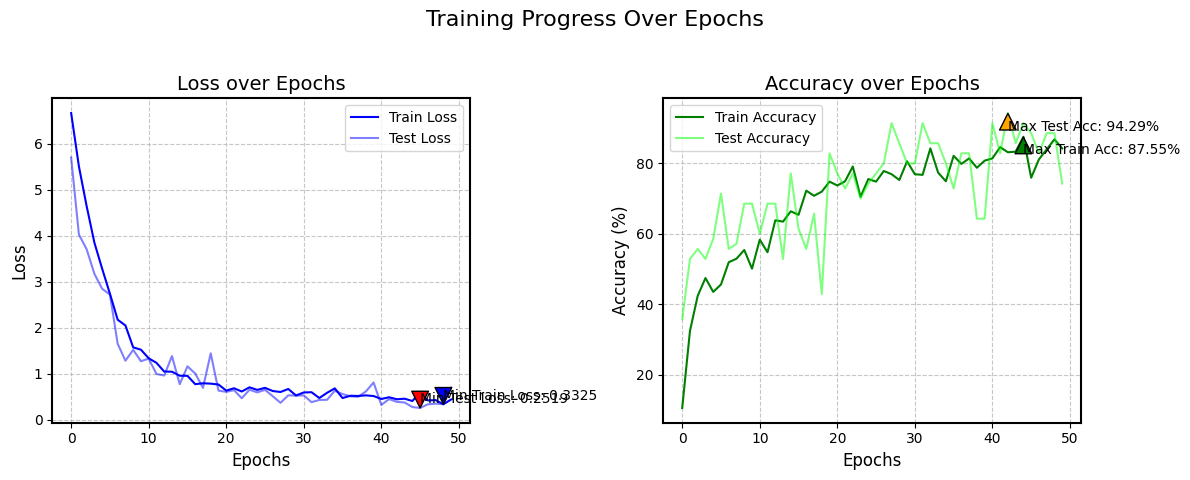

In [21]:
# Visualize the results after training
plot_training_progress(trained_model, result_g_dir)

In [22]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, save_path=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [23]:
# Evaluate The Model
def evaluate_model(model, dataloader, device, class_names, save_path=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred_class = torch.argmax(y_pred, dim=1)
            all_preds.extend(y_pred_class.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    class_metrics = precision_recall_fscore_support(all_labels, all_preds, labels=[0, 1, 2])
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Plot confusion matrices
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plot_confusion_matrix(cm, classes=class_names,
                          title='Confusion Matrix - Without Normalization')

    plt.subplot(1, 2, 2)
    plot_confusion_matrix(cm, classes=class_names, normalize=True,
                          title='Confusion Matrix - Normalized')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()
    
    # Confusion matrix explanation table
    cm_table_df = pd.DataFrame({
        "": ["Actual Benchpress", "Actual Deadlift", "Actual Squat"],
        "Predicted Benchpress": [cm[0, 0], cm[1, 0], cm[2, 0]],
        "Predicted Deadlift": [cm[0, 1], cm[1, 1], cm[2, 1]],
        "Predicted Squat": [cm[0, 2], cm[1, 2], cm[2, 2]]
    })

    # Class Metrics Table
    class_metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision": class_metrics[0],
        "Recall": class_metrics[1],
        "F1 Score": class_metrics[2]
    })
    
    # Weighted Average Metrics Table
    weighted_avg_metrics_df = pd.DataFrame({
        "Metric": ["Precision", "Recall", "F1 Score"],
        "Score": [f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}"]
    })

    # Display DataFrame with borders
    display(HTML(cm_table_df.to_html(index=False, border=1)))
    display(HTML(class_metrics_df.to_html(index=False, border=1)))
    display(HTML(weighted_avg_metrics_df.to_html(index=False, border=1)))

    return cm_table_df, class_metrics_df, weighted_avg_metrics_df, precision, recall, f1, cm

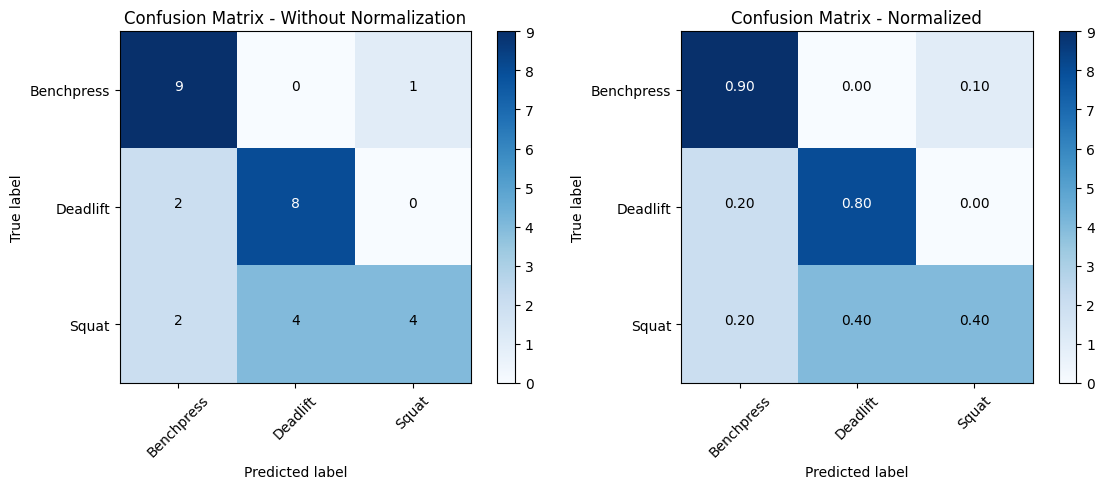

,Predicted Benchpress,Predicted Deadlift,Predicted Squat
Actual Benchpress,9,0,1
Actual Deadlift,2,8,0
Actual Squat,2,4,4


Class,Precision,Recall,F1 Score
Benchpress,0.692308,0.9,0.782609
Deadlift,0.666667,0.8,0.727273
Squat,0.800000,0.4,0.533333


Metric,Score
Precision,0.7197
Recall,0.7000
F1 Score,0.6811


In [24]:
# Display The Evaluation
cm_table_df, class_metrics_df, weighted_avg_metrics_df, precision, recall, f1, cm = evaluate_model(model, test_dataloader, device, class_names, result_cm_dir)

In [25]:
# Function to save evaluation results to CSV in a specified folder
def save_evaluation_results_to_csv(class_metrics_df, weighted_avg_metrics_df, folder_path):
    # Create the folder if it does not exist
    os.makedirs(folder_path, exist_ok=True)
    
    # Save the DataFrames to CSV files in the specified folder
    cm_table_df.to_csv(os.path.join(folder_path, 'cm_table.csv'), index=False)
    class_metrics_df.to_csv(os.path.join(folder_path, 'e_class_f1_score.csv'), index=False)
    weighted_avg_metrics_df.to_csv(os.path.join(folder_path, 'e_avg_f1_score.csv'), index=False)
    
    print(f"Evaluation results saved to CSV files in folder: {folder_path}")


In [26]:
# Save DataFrames to CSV
save_evaluation_results_to_csv(class_metrics_df, weighted_avg_metrics_df, result_e_dir)

Evaluation results saved to CSV files in folder: ./training_results/batch_size_7/scene_6


In [27]:
# Save the model 
model.eval()
torch.save(model.state_dict(), result_m_dir)

In [47]:
# Load the model
loaded_model = mobilevig.mobilevig_s(num_classes=len(class_names))
loaded_model.load_state_dict(torch.load("./training_results/batch_size_7/scene_6/m_MobileViG_s_50_epoch_0.5_d.pth"))
loaded_model.to(device)

C:\Users\affan\AppData\Local\Temp\ipykernel_12580\291909183.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("./training_results/b

MobileViG(
  (stem): Stem(
    (stem): Sequential(
      (0): Conv2d(3, 21, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(21, 42, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
    )
  )
  (local_backbone): ModuleList(
    (0): InvertedResidual(
      (mlp): MLP(
        (fc1): Conv2d(42, 168, kernel_size=(1, 1), stride=(1, 1))
        (act): GELU(approximate='none')
        (fc2): Conv2d(168, 42, kernel_size=(1, 1), stride=(1, 1))
        (drop): Dropout(p=0.0, inplace=False)
        (mid): Conv2d(168, 168, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=168)
        (mid_norm): BatchNorm2d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm1): BatchNorm2d(168, eps=1e-

In [48]:
# Prediction function
def predict_image(model, img_path, transform, class_names):
    model.eval()
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
    probabilities = torch.softmax(output, dim=1)[0] * 100
    _, predicted_idx = torch.max(output, 1)
    predicted_class = class_names[predicted_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {predicted_class}')
    plt.show()

    # Ensure the lengths of class_names and probabilities match
    probabilities = probabilities[:len(class_names)]

    # Create DataFrame
    confidence_df = pd.DataFrame({
        "Class": class_names,
        "Confidence": [f"{prob:.2f}%" for prob in probabilities.cpu().numpy()]
    }).sort_values(by="Confidence", ascending=False)

    # Display DataFrame with borders
    display(HTML(confidence_df.to_html(index=False, border=1)))

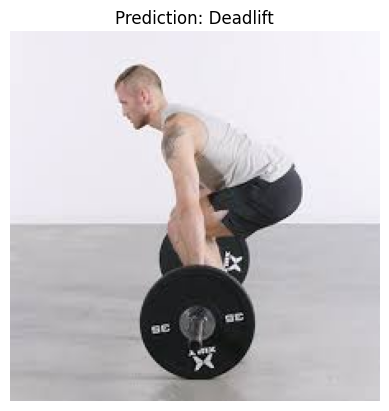

Class,Confidence
Deadlift,72.72%
Benchpress,26.49%
Squat,0.05%


In [67]:
# Example usage for prediction
test_img_path = "./custom-data/good_deadlift_1.jpeg"  # Replace with your own image path
predict_image(loaded_model, test_img_path, test_transforms, class_names)